
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 6 - Actor Critic part 2 </b></center></h2>

<br>
<center><font size="3">This notebook is part of the teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Deep Deterministic Policy Gradient</a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#8.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Implement DDPG algorithm (25 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Reasons for using off-policy data (10 points) </a>\
<a href='#Q2'><b>Student Question 2</b> Disadvantages of DDPG (10 points) </a>

    
**Total Points:** 45

# 1. Introduction <a id='1.'></a>
In this assignment, we will implement the Deep Deterministic Policy Gradient (DDPG) [1] algorithm for the **HalfCheetah-v4** environment. DDPG is a reinforcement learning algorithm that uses a critic, approximated as a neural network, to estimate values. DDPG uses policy gradient methods to update a deterministic policy (actor) to follow the critic. DDPG can be applied to problems with a continuous action space.

## 1.1 Task environments: <a id='1.1'></a>

In this exercise, we will focus on HalfCheetah-v4 tasks:
- HalfCheetah-v4(https://gymnasium.farama.org/environments/mujoco/half_cheetah/): The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torques on the joints to make the cheetah run forward (right) as fast as possible, with a positive reward allocated based on the distance moved forward and a negative reward allocated for moving backward. The torso and head of the cheetah are fixed, and the torque can only be applied on the other 6 joints over the front and back thighs (connecting to the torso), shins (connecting to the thighs) and feet (connecting to the shins).
<figure style="text-align: center">
    <img src="imgs/HalfCheetah-v4.png" width="300"/>
    <figcaption style="text-align: center">  Figure 1: The HalfCheetah-v4 environment. </figcaption>
</figure>

## 1.2 Learning Objectives: <a id='1.2'></a>

- Understand the DDPG algorithm
- Understand the difference between on-policy methods and off-policy methods

## 1.3 Code Structure & Files <a id='1.3'></a>

```ex6_DDPG.ipynb``` is the file needed to be modified for this part of the assignment.  

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER PART IN ```ex6_PG_AC.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───HalfCheetah-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*HalfCheetah-v4_params.pt    # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*ddpg.png               # Contains training performance plot
│   └───InvertedPendulum-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*InvertedPendulum-v4_params.pt      # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*pg_ac.png              # Contains training performance plot
│   ex6_DDPG.ipynb                  # 2nd assignment file containing tasks <---------This task
│   ex6_PG_AC.ipynb                 # 1st assignment file containing tasks <---------
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```

## 1.4 Execution time <a id='1.4'></a>

The training of DDPG might take more than 30 min depending on server load. If you have problems with the training time, you can train DDPG locally.

# 2. Deep Deterministic Policy Gradient <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing DDPG (25 points) </h3> 

Implement the deep deterministic policy gradient (DDPG) algorithm for the HalfCheetah environment. You can refer to the code from the "ex4_dqn.ipynb" notebook for guidance. Additionally, if necessary, consult the paper [1] for a deeper understanding of the algorithm. You can check the training performance plot in the result folder after running the plot cell.Take Figure 2 as a reference training plot. 

<figure style="text-align: center">
<img src="imgs/ddpg.png" width="400px">
<figcaption style="text-align: center"> Figure 2:  Training plot of the deterministic policy gradient on the HalfCheetah environment.
</figcaption>
</figure>

**Complete the unfinished implementation in the `DDPG` class (marked with ```TODOs```)**. 
    
1. **Agent Update Function**: Finish the `_update(self, )` function within the `DDPG` class
2. **Get Action Method**: Finish the `get_action(self, observation, evaluation=False)` function within the `DDPG` class.

**Hint:** Make always sure variables have correct dimensions!
    
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
import copy, torch, yaml,time
import torch.nn.functional as F
from torch import nn
import numpy as np
from pathlib import Path
from IPython.display import Video
from buffer import ReplayBuffer
import train as t
import utils as u
device = 'cpu'

In [3]:
# Actor-critic agent

# Policy class. The policy is represented by a neural network. 
# Reminder: in DDPG the policy is deterministic.
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.max_action = max_action
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, state):
        return self.max_action * torch.tanh(self.actor(state))


# Critic class. The critic is represented by a neural network.
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.value = nn.Sequential(
            nn.Linear(state_dim+action_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1))

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        return self.value(x) # output shape [batch, 1]


class DDPG(object):
    def __init__(self, state_shape, action_dim, max_action, lr, gamma, tau, batch_size, buffer_size=1e6):
        self.name = 'ddpg'
        state_dim = state_shape[0]
        self.action_dim = action_dim
        self.max_action = max_action
        self.pi = Policy(state_dim, action_dim, max_action).to(device)
        self.pi_target = copy.deepcopy(self.pi)
        self.pi_optim = torch.optim.Adam(self.pi.parameters(), lr=float(lr))

        self.q = Critic(state_dim, action_dim).to(device)
        self.q_target = copy.deepcopy(self.q)
        self.q_optim = torch.optim.Adam(self.q.parameters(), lr=float(lr))
        
        self.buffer = ReplayBuffer(state_shape, action_dim, max_size=int(float(buffer_size)))
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        
        # used to count number of transitions in a trajectory
        self.buffer_ptr = 0
        self.buffer_head = 0 
        self.random_transition = 5000 # collect 5k random data for better exploration
    

    def update(self,):
        """ After collecting one trajectory, update the pi and q for #transition times: """
        info = {}
        update_iter = self.buffer_ptr - self.buffer_head # update the network once per transition

        if self.buffer_ptr > self.random_transition: # update once we have enough data
            for _ in range(update_iter):
                info = self._update()
        
        # update the buffer_head:
        self.buffer_head = self.buffer_ptr
        return info


    def _update(self,):
        # get batch data
        batch = self.buffer.sample(self.batch_size, device=device)
        # batch contains:
        #    state = batch.state, shape [batch, state_dim]
        #    action = batch.action, shape [batch, action_dim]
        #    next_state = batch.next_state, shape [batch, state_dim]
        #    reward = batch.reward, shape [batch, 1]
        #    not_done = batch.not_done, shape [batch, 1]

        # TODO:
        ########## Your code starts here. ##########
        # Hints: 1. compute the Q target with the q_target and pi_target networks
        #        2. compute the critic loss and update the q's parameters
        #        3. compute actor loss and update the pi's parameters
        #        4. update the target q and pi using u.soft_update_params() (See the DQN code)
        
        # compute current q
        current_q_target = self.q(batch.state, batch.action)
        
        # compute target q
        with torch.no_grad():
            next_action = self.pi_target(batch.next_state).clamp(-self.max_action, self.max_action)
            next_q_target = self.q_target(batch.next_state, next_action)
            tq_target = batch.reward + self.gamma * next_q_target * batch.not_done
        
        # compute critic loss
        critic_loss = F.mse_loss(current_q_target, tq_target)

        # optimize the critic
        self.q_optim.zero_grad()
        critic_loss.backward()
        self.q_optim.step()

        # compute actor loss
        actor_loss = -self.q(batch.state, self.pi(batch.state)).mean()

        # optimize the actor
        self.pi_optim.zero_grad()
        actor_loss.backward()
        self.pi_optim.step()

        # update the target q and target pi using u.soft_update_params() function
        u.soft_update_params(self.q, self.q_target, self.tau)
        u.soft_update_params(self.pi, self.pi_target, self.tau)
        ########## Your code ends here. ##########

        return {}

    
    @torch.no_grad()
    def get_action(self, observation, evaluation=False):
        if observation.ndim == 1: observation = observation[None] # add the batch dimension
        x = torch.from_numpy(observation).float().to(device)

        if self.buffer_ptr < self.random_transition: # collect random trajectories for better exploration.
            action = torch.rand(self.action_dim)
        else:
            expl_noise = 0.1 * self.max_action # the stddev of the expl_noise if not evaluation
            
            # TODO:
            ########## Your code starts here. ##########
            # Use the policy to calculate the action to execute
            # if evaluation equals False, add normal noise to the action, where the std of the noise is expl_noise
            # Hint: Make sure the returned action's shape is correct.

            action = self.pi(x)

            if not evaluation:
                action += torch.rand(self.action_dim) * expl_noise
                
            ########## Your code ends here. ##########

        return action, {} # just return a positional value


    def record(self, state, action, next_state, reward, done):
        """ Save transitions to the buffer. """
        self.buffer_ptr += 1
        self.buffer.add(state, action, next_state, reward, done)
    

    def load(self, filepath):
        d = torch.load(filepath)
        self.q.load_state_dict(d['q'])
        self.q_target.load_state_dict(d['q_target'])
        self.pi.load_state_dict(d['pi'])
        self.pi_target.load_state_dict(d['pi_target'])
    
    def save(self, filepath):
        torch.save({
            'q': self.q.state_dict(),
            'q_target': self.q_target.state_dict(),
            'pi': self.pi.state_dict(),
            'pi_target': self.pi_target.state_dict()
        }, filepath)


In [4]:
# initialize the agent
with open(Path().cwd()/'cfg'/'ddpg.yaml', 'r') as f:
    cfg = u.Struct(**yaml.safe_load(f))

agent = DDPG(cfg.state_shape, cfg.action_dim, cfg.max_action,
             cfg.lr, cfg.gamma, cfg.tau, cfg.batch_size, cfg.buffer_size)

In [9]:
# train the agent, training should take roughly 35min
t.train(agent, cfg_path=Path().cwd()/'cfg'/'ddpg.yaml', cfg_args={})

Numpy/Torch/Random Seed:  294
{'episode': 0, 'timesteps': 1000, 'ep_reward': -173.16647416713394}
{'episode': 50, 'timesteps': 1000, 'ep_reward': 3948.637306065593}
{'episode': 100, 'timesteps': 1000, 'ep_reward': 3538.166800769599}
{'episode': 150, 'timesteps': 1000, 'ep_reward': 3764.31716728612}
{'episode': 200, 'timesteps': 1000, 'ep_reward': 3977.036732236086}
{'episode': 250, 'timesteps': 1000, 'ep_reward': 4015.192057701514}
{'episode': 300, 'timesteps': 1000, 'ep_reward': 4069.2289907780446}
Saving model to /notebooks/rl2023/ex6/results/HalfCheetah-v4/model/HalfCheetah-v4_params.pt
------ Training Finished ------
Total traning time is 10.770597863197327mins


Numpy/Torch/Random Seed:  362


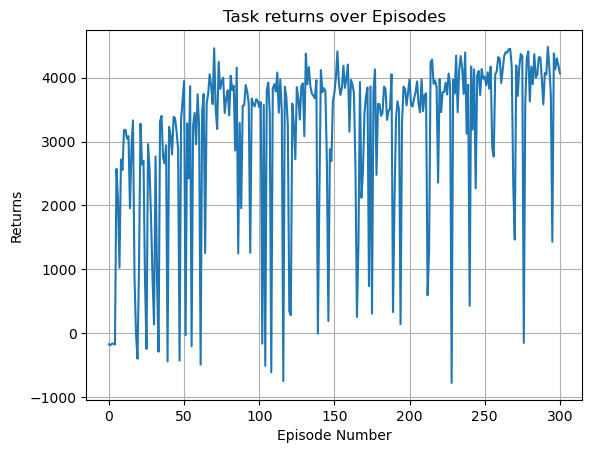

In [10]:
# plot training performance
t.plot(cfg_path=Path().cwd()/'cfg'/'ddpg.yaml',)

In [11]:
# test the trained policy and save a video of the test
t.test(agent, cfg_path=Path().cwd()/'cfg'/'ddpg.yaml', cfg_args=dict(save_video=True,testing=True))

Numpy/Torch/Random Seed:  668
Loading model from /notebooks/rl2023/ex6/results/HalfCheetah-v4/model/HalfCheetah-v4_params.pt ...
Testing ...
Moviepy - Building video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4.
Moviepy - Writing video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4
Ep0: Test ep_reward is 4222.592235469021
Ep1: Test ep_reward is 4548.988071548869
Ep2: Test ep_reward is 4381.853679504878
Ep3: Test ep_reward is 4574.276922958019
Ep4: Test ep_reward is 4475.338799817549
Ep5: Test ep_reward is 3876.5804628898472
Ep6: Test ep_reward is 4483.102455622401
Ep7: Test ep_reward is 4011.9360146335666
Ep8: Test ep_reward is -137.28637644286795
Moviepy - Building video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4.
Moviepy - Writing video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4
Ep9: Test ep_reward is 4707.095008751172
Average test reward: 3914.4477274752453


In [12]:
Video(Path().cwd()/'results'/'HalfCheetah-v4'/'video'/'test'/'ex6-episode-9.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> On-policy vs off-policy part 1 (10 points) </h3> 

For policy gradient methods seen in Exercise 5, we update the agent using only on-policy data, while in DDPG we can use off-policy data. Why? (Try to answer in 5 sentences)

🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

These equations are from the paper "Deterministic Policy Gradient Algorithms" [2]

The on-policy data of policy gradient formula is:
\begin{equation}
\begin{split}
\nabla_\theta J(\pi_\theta) & = \int_S \rho^\pi(s) \int_A \nabla_\theta \pi_\theta (a|s) Q^{\pi} (s,a) ds \\ &= \mathbb{E}_{s \sim \rho^\pi , a \sim \pi_\theta} [\nabla-\theta \log \pi_\theta (a|s) Q^{\pi} (s,a)] 
\end{split}
\end{equation}

$\pi_\theta$: The stochastic policy being optimized, parameterized by $\theta$

$\rho^\pi$: The state distribution under policy $\pi$

On-policy data: The expectation is taken over states and actions sampled according to the stochastic policy $\pi_\theta$ being optimized. This means that the data used to update the policy must be collected using the same policy. Therefore, the equation says that we must use only on-policy data to update the policy gradient. 


The off-policy data of DDPG formula is:


\begin{equation}
\begin{split}
\nabla_\theta J_\beta(\mu_\theta) & \approx \int_S \rho^\beta(s) \nabla_\theta \mu_\theta (a|s) Q^{\mu} ds \\ &= \mathbb{E}_{s \sim \rho^\pi} [\nabla_\theta \mu_\theta (s) \nabla_a Q^{\mu} (s,a) |_{a=\mu_\theta (s)}] 
\end{split}
\end{equation}

where:

$\mu_\theta$: The deterministic policy being optimized, parameterized by $\theta$

$\rho^{\beta}$ : The state distribution under the behavior policy $\beta$, which can be different from the target policy $\mu$

Off-policy data: The expectation is taken over states sampled according to some distribution $\rho^\pi$, which is not necessarily the distribution produced by the target policy $\mu_\theta$. This allows for learning from data collected under different policies. Therefore, the formula says that we can use off-policy data to update the policy gradient of the actor. Additionally, DDPG also uses Q-learning, which also uses off-policy data, to update the critic's parameters. 

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> On-policy vs off-policy part 2 (10 points) </h3> 

A big advantage of DDPG, compared to policy gradient, is that it’s able to utilise off-policy data. What are the disadvantages of deterministic policy gradient compared to the policy gradient method implemented in ex6_PG_AC.ipynb? List two of them.

🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

- The first disadvantage of deterministic policy gradient is that it has limited capacity to conduct exploration. Because deterministic policies always select the same action for a given state, it will lead to inadequate exploration of the state-action space. On the other hand, stochastic policies favor diverse exploration by sampling actions from a distribution. 

- The second disadvantage of deterministic policy gradient is that it overestimates Q-values.
This happens when the noise in the environment in the Q-function is positively biased. For stochastic policies, they enable exploration by sampling actions from a distribution. This can prevent the policy from repeatedly choosing the actions with  highest Q-values.

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex6_DDPG.ipynb``` and ```ex6_PG_AC.ipynb```) are answered and the necessary plots are saved in the appropriate locations. The relevant plots and files that need to be submitted for this assignment are:


- Training performance plots:
  - `ddpg.png`: Training performance plots in terms of episode and episodic reward for DDPG
<br>

  
- Model files:
  - `ddpg_params.pt`: Trained model


Ensure the model files and plots are saved in correct paths:
- ```results/HalfCheetah-v4/ddpg.png``` Training result
- ```results/HalfCheetah-v4/model/ddpg_params.pt``` Training Model


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex6_PG_AC.ipynb```** </span>

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [13]:
hrs = 5

2) Difficulty of each task/question from 1-5 (int or float)

In [14]:
T1 = 5   # Implementing DDPG (20 points)
Q1 = 5   # Question 1.1 Reasons of using off-policy data (10 points)
Q2 = 5   # Question 1.2 Disadvantages of DDPG (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [15]:
T1 = 5   # Implementing DDPG (20 points)
Q1 = 5   # Question 1.1 Reasons of using off-policy data (10 points)
Q2 = 5   # Question 1.2 Disadvantages of DDPG (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

After this assignment, I can see that DDPG addresses the challenges of continuous action spaces in RL. By combining the strengths of actor-critic methods and deep neural networks, DDPG achieves stable and efficient learning in complex environments.

# References <a id='3.'></a>
Please use the following section to record references.

[1] Timothy P. Lillicrap et al. "Continuous control with deep reinforcement learning" ICLR 2016 https://arxiv.org/abs/1509.02971

[2] Silver, David & Lever, Guy & Heess, Nicolas & Degris, Thomas & Wierstra, Daan & Riedmiller, Martin. (2014). Deterministic Policy Gradient Algorithms. 31st International Conference on Machine Learning, ICML 2014. 1. 
http://proceedings.mlr.press/v32/silver14.pdf